# Rendering Aus400 data with pillow

The data size of Aus400 is too large to effectively plot the whole domain with matplotlib. It is possible however to use the imaging library '[pillow](https://pillow.readthedocs.io/en/stable/)' to create a png image. This is what I used for the pre-visualisation animations.

While the library is called pillow, you import it as `PIL` for historical reasons

In [1]:
import sys
sys.path.append('../')

import aus400
import PIL
import dask
import dask.diagnostics
import tempfile

In [2]:
client = dask.distributed.Client(local_directory=tempfile.TemporaryDirectory().name)
client

Client Scheduler: tcp://127.0.0.1:35479 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.56 GB


## Choosing Variables

First let's choose a variable to plot - streams 'spec' and 'slv' hold single level fields, so let's start with one from those:

In [3]:
aus400.filter_catalogue(resolution='d0036', stream='spec')['variable'].unique()

array(['abl_ht', 'accum_ls_prcp', 'accum_ls_snow', 'aero_r', 'dewpt_scrn',
       'flash_rate', 'hi_cld', 'low_cld', 'max_refl', 'max_wndgust10m',
       'mid_cld', 'mslp', 'n_lightning_fl', 'pressure', 'qsair_scrn',
       'sfc_pres', 'sfc_temp', 'spec_hum', 'storm_loc_flag', 'temp_scrn',
       'tiles_coeffs_ratio', 'tiles_pot_et', 'tiles_r_evap', 'ttl_cld',
       'ttl_col_dry_mass', 'ttl_col_qcf', 'ttl_col_qcl',
       'ttl_col_wet_mass', 'uwnd10m', 'vwnd10m', 'wndgust10m'],
      dtype=object)

In [4]:
max_refl = aus400.load(resolution='d0036', stream='spec', variable='max_refl')['max_refl']

A single timestep is over half a GB

In [5]:
field = max_refl.sel(time='20170328T1200')

field.data

dask.array<getitem, shape=(10554, 13194), dtype=float32, chunksize=(500, 500), chunktype=numpy.ndarray>

### Converting to a byte array

To make a useful image we'll need to normalise the values, so that they lie between 0 and 1. We'll also take the opportunity to convert to a byte array to cut down on space.

This gives us a 140 MB array we can play with using pillow

In [6]:
vmin = field.min().values
vmax = field.max().values

normalised_field = (field - vmin)/(vmax - vmin)

def to_bytes(array):
    """
    Convert an array of floats between 0 and 1 to bytes between 0 and 255
    """
    return (array * (2**8-1)).astype('uint8')

byte_field = to_bytes(normalised_field)

byte_field.data

dask.array<astype, shape=(10554, 13194), dtype=uint8, chunksize=(500, 500), chunktype=numpy.ndarray>

# Making an image

Pillow has a handy function for creating an image from a numpy array (you have to use .values here to get a numpy array from xarray)

'mode' gives information about what the array contains. We have a single byte for each pixel of the image, which is `L`. It can also take an array with red, green and blue values, but we'll get to that

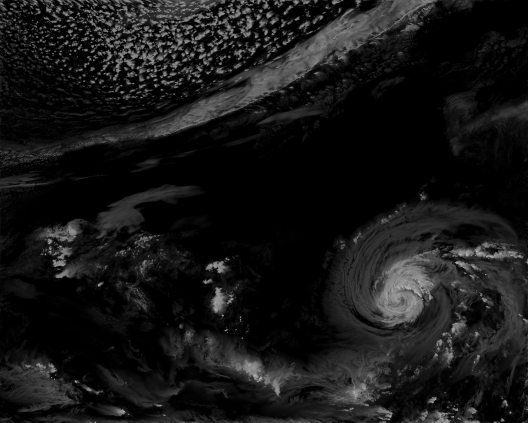

In [7]:
image = PIL.Image.fromarray(byte_field.values, mode='L')

# The image is still pretty big, for display in the notebook I'll be reducing the size by 20x
image.reduce(25)

Note the image is flipped top to bottom - this is just how pillow handles the origin. You can flip the image quite simply

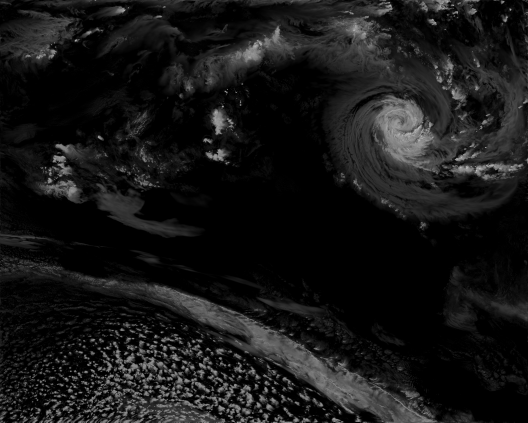

In [8]:
image = image.transpose(PIL.Image.FLIP_TOP_BOTTOM)

image.reduce(25)

## Adding colour

We can add a colour map by defining the red green and blue values for each level in the image with a pallet. A good source of pallets is matplotlib - if you give a matplotlib colour map a value between 0 and 1 it will give the colour information for that value.

In [9]:
import matplotlib.pyplot as plt
import numpy

cmap = plt.get_cmap('cividis')
cmap(0.01)

(0.0, 0.141013, 0.317579, 1.0)

Here I've got the colour map values for each level in my image (256 values between 0 and 1), then converted the values to bytes since that's what pillow needs.

The fourth value from the colour map is an alpha value, we'll get to that next

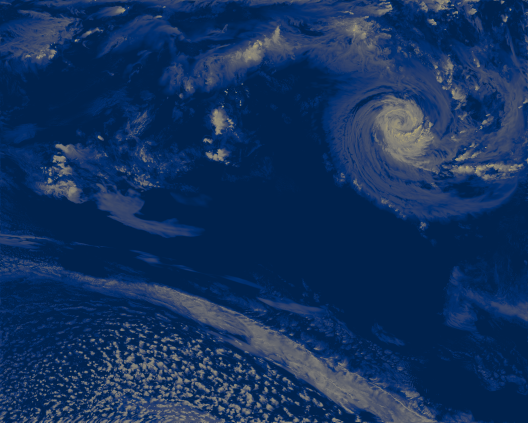

In [10]:
value_levels = numpy.linspace(0,1,2**8)

pallet = to_bytes(cmap(value_levels))[:,0:3]

image.putpalette(pallet, 'RGB')
image.convert(mode='RGB').reduce(25)

## Layering images

You can layer images on top of each other by setting the 'alpha' channel. This gives the amount of transparency for each value in the image.

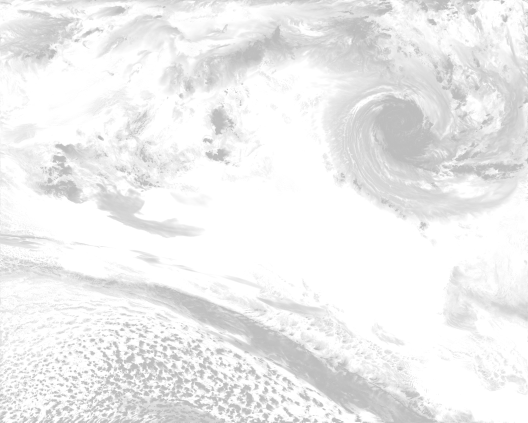

In [11]:
# A simple linear alpha channel using the values from the image
alpha = PIL.Image.fromarray(byte_field.values, mode='L').transpose(PIL.Image.FLIP_TOP_BOTTOM)

image.putalpha(alpha)

image.convert('RGBA').reduce(25)

In [12]:
temp_scrn = aus400.load(resolution='d0036', stream='spec', variable='temp_scrn')['temp_scrn'].sel(time=field.time)

def field_to_image(field):
    vmin = field.min().values
    vmax = field.max().values

    normalised_field = (field - vmin)/(vmax - vmin)
    byte_field = to_bytes(normalised_field)

    return PIL.Image.fromarray(byte_field.values, mode='L').transpose(PIL.Image.FLIP_TOP_BOTTOM)

def set_image_mpl_cmap(image, cmap):
    cmap = plt.get_cmap(cmap)
    value_levels = numpy.linspace(0,1,2**8)
    pallet = to_bytes(cmap(value_levels))[:,0:3]
    image.putpalette(pallet, 'RGB')
    
temp_scrn_img = field_to_image(temp_scrn)
set_image_mpl_cmap(temp_scrn_img, 'viridis')

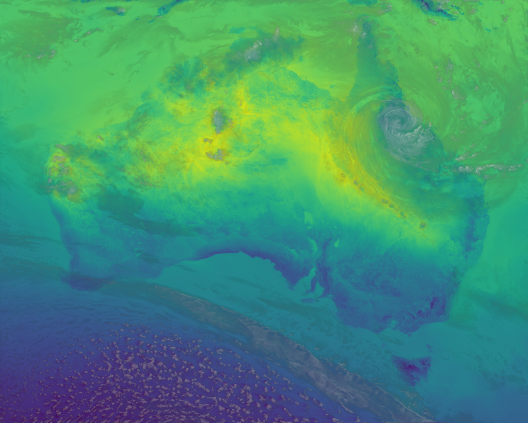

In [13]:
composite = PIL.Image.alpha_composite(temp_scrn_img.convert('RGBA'), image.convert('RGBA'))

composite.reduce(25)

## Zooming In

While I'm only showing a zoomed out view of the images, they are at the full Aus400 resolution with 1 pixel = 1 model grid point.

We can zoom in on a specific location by specifying a box of indices

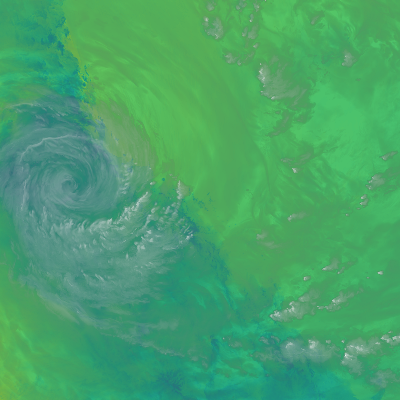

In [14]:
target = (148.716, -20.26)
size = 10

x0 = temp_scrn.indexes['longitude'].get_loc(target[0]-size/2, method='nearest')
x1 = temp_scrn.indexes['longitude'].get_loc(target[0]+size/2, method='nearest')

y0 = temp_scrn.sizes['latitude'] - temp_scrn.indexes['latitude'].get_loc(target[1]-size/2, method='nearest')
y1 = temp_scrn.sizes['latitude'] - temp_scrn.indexes['latitude'].get_loc(target[1]+size/2, method='nearest')

composite.transform(size=(400,400),
                    method=PIL.Image.QUAD,
                    data=(x0,y1,x0,y0,x1,y0,x1,y1),
                    resample=PIL.Image.BICUBIC,
                    fillcolor=(0,0,0,255))

## Helpful Functions

Functions for rendering Aus400 data using pillow are available in [`aus400.render`](https://aus400-cookbook.readthedocs.io/en/latest/api/aus400.html#module-aus400.render), which cover the ideas shown here